# **Proyecto Final Optimización: SVM**
Por: Shadia Jaafar

# Introducción

Support Vector Machine (SVM) es un algoritmo de aprendizaje supervisado usado para resolver problemas de clasificación y regresión. El objetivo es encontrar un hiperplano que maximice el margen de separación entre dos clases de datos.

En este trabajo se abordarán problemas de clasificación binaria usando el conjunto de datos *Iris* de la librería *sklearn*, este datset contiene las medidas de longitud y ancho de pétalos y sépalos de tres especies de flores. Además, el proyecto SVM tiene como objetivo analizar los problemas primal y dual de las máquinas de vectores de soporte para el caso separable.




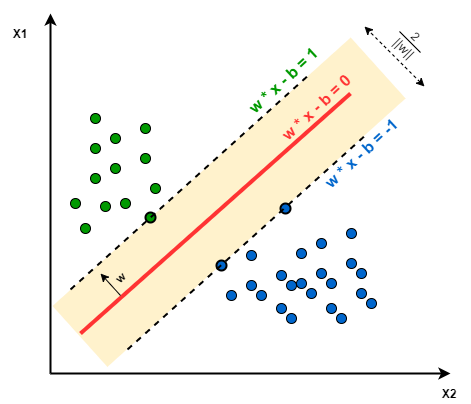

En primer lugar, se resolverán el problema primal y dual para clasificar las especies de flores Setosa y Versicolor. Posteriormente, se repetirán los pasos anteriores para clasificar las especies Versicolor y Virgínica. \\

Para resolver el problema primal usaremos la función *Problem* de la librería *cvxpy*.



Las librerías que se utilizaron para la realización de este trabajo fueron las siguientes:

### Librerías

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint
import scipy.io

### Conjunto de datos utilizado

In [ ]:
iris = datasets.load_iris()
X = iris.data # Variables explicativas
y = iris.target # Variable Respuesta

# Desarrollo

Iniciemos escribiendo las funciones objetivos a minimizar.

## Problema Primal de SVM
$min_{w, b} \frac{1}{2} |||w||^2$

Sujeto a: $y_i(w^Tx_i + b) \geq 1$ $\forall i = 1, \cdots, n$


## Problema Dual de SVM
$\min \frac{1}{2} \alpha^t\hat{p}\alpha - e^t\alpha$

$p_{ij} = y_iy_jx_i^tx_j$, $ \quad e = \begin{equation*}
\begin{pmatrix}
1\\
1\\
\vdots \\
1
\end{pmatrix}
\end{equation*}$,
$\quad y=\begin{equation*}
\begin{pmatrix}
y_1\\
y_2\\
\vdots \\
y_n
\end{pmatrix}
\end{equation*}$

## **Caso Separable:** Clasificación Setosa y Versicolor

In [ ]:
# Filtrar las clases setosa (0) y versicolor (1)
X_subset = X[y != 2]
y_subset = y[y != 2]

# Cambiar las etiquetas a {-1, 1} setosa = -1, versicolor = 1
y_subset = 2 * y_subset - 1

### Problema primal


In [ ]:
w = cp.Variable(X_subset.shape[1])
b = cp.Variable()

# Restricciones
constraints = [y_subset[i] * (X_subset[i] @ w + b) >= 1 for i in range(len(y_subset))]

# Función objetivo
objective = cp.Minimize(0.5 * cp.norm(w)**2)

# Problema de optimización
problem = cp.Problem(objective, constraints)

# Resolver el problema
problem.solve()

# Obtener los valores óptimos
w_optimal = w.value
b_optimal = b.value

print("Vector óptimo (w):", w_optimal)
print("Intercepto (b):", b_optimal)
print("Valor de la función objetivo")
valor = (0.5 * cp.norm(w_optimal)**2).value
print(valor)


Vector óptimo (w): [ 0.04603438 -0.52172249  1.00316436  0.46418056]
Intercepto (b): -1.4505608374882162
Valor de la función objetivo
0.7480579265182639


Aquí podemos observar los coeficientes que describen el hiperplano separador de las dos clases. Además, el valor de la función objetivo cuando se evalúan los valores óptimos.

## Problema Dual
Para hallar la solución del problema dual se requirió del uso de la función *quadprog* del lenguaje de programación MATLAB. A continuación se presenta el código utilizado y el respectivo output.

```matlab
% Dataset Iris
load fisheriris;

% Convertir a numeros las categorias
y = double(categorical(species));

% Seleccionar versicolor y Virginica
indices = (y == 2 | y == 3);
X_subset = meas(indices, :);
y_subset = y(indices);

y_subset(y_subset == 1) = -1; %versicolor
y_subset(y_subset == 2) = 1; %virginica

%Problema Dual------------------------------------------------------------
%min 0.5*alpha^t*p*alpha - e*alpha
%s.a y^t*alpha = 0; alpha>=0

% Matriz pij = y_iy_jx_ix_j
H = zeros(length(y_subset));
for i = 1:length(y_subset)
    for j = 1:length(y_subset)
        H(i, j) = y_subset(i) * y_subset(j) * dot(X_subset(i, :), X_subset(j, :));
    end
end

f = -ones(length(y_subset), 1); %-e

Aeq = y_subset'; %y^t
beq = 0; %restricciones de igualdad
lb = zeros(length(y_subset), 1); %restricciones de desigualdad

% Resolver el problema cuadrático
options = optimoptions('quadprog', 'Algorithm', 'interior-point-convex');
alpha_optimal = quadprog(H, f, [], [], Aeq, beq, lb, [], [], options);

fprintf('Resultado de la optimización:\n');
fprintf('alpha_optimal = \n');
fprintf('%.15f\n', alpha_optimal);

% Valor de la función objetivo
value = 0.5 * alpha_optimal' * H * alpha_optimal + f' * alpha_optimal;
fprintf('Valor de la función objetivo = \n');
fprintf('%.15f\n', value);

% Encontrar los alphas mayores que 0
indices_alpha_positivos = find(alpha_optimal > 0);
fprintf('Valores de alpha mayores que 0:\n');

alpha_optimos = alpha_optimal(indices_alpha_positivos);
disp(alpha_optimos);

% Vectores de Soporte-------------------------------------------------
X_filas_alpha_positivos = X_subset(indices_alpha_positivos, :);

fprintf('Vectores de Soporte:\n');
disp(X_filas_alpha_positivos);

save('soluciones_2.mat', 'alpha_optimos', 'X_filas_alpha_positivos');



```
Output:

alpha_optimos =

    0.6713
    0.0767
    0.7481

Vectores de Soporte = \\
    5.1000    3.3000    1.7000    0.5000 \\
    4.5000    2.3000    1.3000    0.3000 \\
    5.1000    2.5000    3.0000    1.1000

Valor de la función objetivo = -0.748058
```

Se hallaron 3 multiplicadores de Lagrange y sus vectores de soporte correspondientes. Por otro lado, el valor de la función primal es aproximadamente igual a menos el valor de la función dual. Esto demustra que hallar la solución del problema dual, es equivalente a hallar la solución del problema primal.

*Nota:* debido a que los valores obtenidos fueron hallados en MATLAB se recurrió guardar los datos en un archivo y posteriormente cargarlos en Python para implementar los ejercicios siguientes.

En este código se muestra el proceso de cargue del archivo y la obtención de los datos.

In [ ]:
mat_data = scipy.io.loadmat('soluciones_1.mat')

alpha = mat_data['alpha_optimos']
vectores = mat_data['X_filas_alpha_positivos']

print("Vectores de Soporte", vectores)
print("Multiplicadores de Lagrange", alpha)

Vectores de Soporte [[5.1 3.3 1.7 0.5]
 [4.5 2.3 1.3 0.3]
 [5.1 2.5 3.  1.1]]
Multiplicadores de Lagrange [[0.67133404]
 [0.07672389]
 [0.74805793]]


### Probar Condiciones de Optimalidad KKT

In [ ]:
condicion = True

for alpha_i, x_i, y_i in zip(alpha, vectores, y_subset):
    condiciones_kkt = abs(alpha_i * (y_i * (np.dot(w_optimal, x_i) + b_optimal) - 1))
    if condiciones_kkt >= 1e-5:
        condicion = False
        break

# Print message if all conditions are met
if condicion:
    print("Todos los vectores satisfacen las condiciones")
else:
    print("No todos los vectores satisfacen las condiciones")

Todos los vectores satisfacen las condiciones


### Error de clasificación

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)

decision_values = np.dot(X_test, w_optimal) + b_optimal
y_pred = np.sign(decision_values)

error_rate = 1 - np.sum(y_pred == y_test) / len(y_test)

print(f"Classification Error Rate: {error_rate:.2%}")

Classification Error Rate: 0.00%


Podemos observar que cuando los datos son linealmente separables no hay errores de clasificación y hay pocos vectores de soporte. Además, se cumplen las condiciones de optimalidad KKT.

## **Caso No Separable:** Clasificación Versicolor y Virgínica

In [ ]:
# Filtrar las clases versicolor (1) y virginica (2)
X_subset = X[y != 0]
y_subset = y[y != 0]

# Cambiar las etiquetas a {-1, 1}
y_subset = 2 * y_subset - 1

### Problema Primal

In [ ]:
w = cp.Variable(X_subset.shape[1])
b = cp.Variable()

# Restricciones
constraints = [y_subset[i] * (X_subset[i] @ w + b) >= 1 for i in range(len(y_subset))]

# Función objetivo
objective = cp.Minimize(0.5 * cp.norm(w)**2)

# Problema de optimización
problem = cp.Problem(objective, constraints)

# Resolver el problema
problem.solve()

# Obtener los valores óptimos
w_optimal = w.value
b_optimal = b.value

print("Vector de pesos óptimo (w):", w_optimal)
print("Término de sesgo óptimo (b):", b_optimal)


Vector de pesos óptimo (w): [-1.84830903e-07 -1.29943970e-07 -8.31403187e-08  8.32640084e-08]
Término de sesgo óptimo (b): 3.2808696905290597


### Problema Dual
Al igual que en el caso anterior, se utilizó la función *quadprog* de MATLAB para hallar la solución del problema dual. El código utilizado fue el siguiente.

```matlab
% Dataset Iris
load fisheriris;

% Convertir a numeros las categorias
y = double(categorical(species));

% Seleccionar versicolor y Virginica
indices = (y == 2 | y == 3);
X_subset = meas(indices, :);
y_subset = y(indices);

y_subset(y_subset == 1) = -1; %versicolor
y_subset(y_subset == 2) = 1; %virginica

%Problema Dual------------------------------------------------------------
%min 0.5*alpha^t*p*alpha - e*alpha
%s.a y^t*alpha = 0; alpha>=0

% Matriz pij = y_iy_jx_ix_j
H = zeros(length(y_subset));
for i = 1:length(y_subset)
    for j = 1:length(y_subset)
        H(i, j) = y_subset(i) * y_subset(j) * dot(X_subset(i, :), X_subset(j, :));
    end
end

f = -ones(length(y_subset), 1); %-e

Aeq = y_subset'; %y^t
beq = 0; %restricciones de igualdad
lb = zeros(length(y_subset), 1); %restricciones de desigualdad

% Resolver el problema cuadrático
options = optimoptions('quadprog', 'Algorithm', 'interior-point-convex');
alpha_optimal = quadprog(H, f, [], [], Aeq, beq, lb, [], [], options);

fprintf('Resultado de la optimización:\n');
fprintf('alpha_optimal = \n');
fprintf('%.15f\n', alpha_optimal);

% Valor de la función objetivo
value = 0.5 * alpha_optimal' * H * alpha_optimal + f' * alpha_optimal;
fprintf('Valor de la función objetivo = \n');
fprintf('%.15f\n', value);

% Encontrar los alphas mayores que 0
indices_alpha_positivos = find(alpha_optimal > 0);
fprintf('Valores de alpha mayores que 0:\n');

alpha_optimos = alpha_optimal(indices_alpha_positivos);
disp(alpha_optimos);

% Vectores de Soporte-------------------------------------------------
X_filas_alpha_positivos = X_subset(indices_alpha_positivos, :);

fprintf('Vectores de Soporte:\n');
disp(X_filas_alpha_positivos);

save('soluciones_2.mat', 'alpha_optimos', 'X_filas_alpha_positivos');


In [ ]:
mat_data = scipy.io.loadmat('soluciones_2 .mat')

alpha = mat_data['alpha_optimos']
vectores = mat_data['X_filas_alpha_positivos']

print(vectores)
print(alpha)

[[7.  3.2 4.7 1.4]
 [6.4 3.2 4.5 1.5]
 [6.9 3.1 4.9 1.5]
 [5.5 2.3 4.  1.3]
 [6.5 2.8 4.6 1.5]
 [5.7 2.8 4.5 1.3]
 [6.3 3.3 4.7 1.6]
 [4.9 2.4 3.3 1. ]
 [6.6 2.9 4.6 1.3]
 [5.2 2.7 3.9 1.4]
 [5.  2.  3.5 1. ]
 [5.9 3.  4.2 1.5]
 [6.  2.2 4.  1. ]
 [6.1 2.9 4.7 1.4]
 [5.6 2.9 3.6 1.3]
 [6.7 3.1 4.4 1.4]
 [5.6 3.  4.5 1.5]
 [5.8 2.7 4.1 1. ]
 [6.2 2.2 4.5 1.5]
 [5.6 2.5 3.9 1.1]
 [5.9 3.2 4.8 1.8]
 [6.1 2.8 4.  1.3]
 [6.3 2.5 4.9 1.5]
 [6.1 2.8 4.7 1.2]
 [6.4 2.9 4.3 1.3]
 [6.6 3.  4.4 1.4]
 [6.8 2.8 4.8 1.4]
 [6.7 3.  5.  1.7]
 [6.  2.9 4.5 1.5]
 [5.7 2.6 3.5 1. ]
 [5.5 2.4 3.8 1.1]
 [5.5 2.4 3.7 1. ]
 [5.8 2.7 3.9 1.2]
 [6.  2.7 5.1 1.6]
 [5.4 3.  4.5 1.5]
 [6.  3.4 4.5 1.6]
 [6.7 3.1 4.7 1.5]
 [6.3 2.3 4.4 1.3]
 [5.6 3.  4.1 1.3]
 [5.5 2.5 4.  1.3]
 [5.5 2.6 4.4 1.2]
 [6.1 3.  4.6 1.4]
 [5.8 2.6 4.  1.2]
 [5.  2.3 3.3 1. ]
 [5.6 2.7 4.2 1.3]
 [5.7 3.  4.2 1.2]
 [5.7 2.9 4.2 1.3]
 [6.2 2.9 4.3 1.3]
 [5.1 2.5 3.  1.1]
 [5.7 2.8 4.1 1.3]
 [6.3 3.3 6.  2.5]
 [5.8 2.7 5.1 1.9]
 [7.1 3.  5.

### Probar condiciones KKT

In [ ]:
condicion = True

for alpha_i, x_i, y_i in zip(alpha, vectores, y_subset):
    condiciones_kkt = alpha_i * (y_i * (np.dot(w_optimal, x_i) + b_optimal) - 1)

    if abs(condiciones_kkt) >= 1e-5:
        condicion = False
        break

# Print message if all conditions are met
if condicion:
    print("Todos los vectores satisfacen las condiciones")
else:
    print("No todos los vectores satisfacen las condiciones")

Todos los vectores satisfacen las condiciones


### Error de Clasificación

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)

decision_values = np.dot(X_test, w_optimal) + b_optimal
y_pred = np.sign(decision_values)

error_rate = 1 - np.sum(y_pred == y_test) / len(y_test)

print(f"Classification Error Rate: {error_rate:.2%}")

Classification Error Rate: 40.00%


Se observa que al ser clases no separables, el error de clasificación es del 40% y hay muchos vectores de soporte.

## Variables de Holgura

$min \frac{1}{2} ||w||^2 + c ∑_{i=1}^n \xi^2$

$s.a \quad y_i(w^tx_i + b) \geq 1 - \xi_1; \quad \xi_i \geq 0  \quad \forall i = 1, \cdots, n$

donde **c>0** es el parámetro de penalización.

In [ ]:
def holgura(C):
  w = cp.Variable(X_subset.shape[1])
  b = cp.Variable()
  s = cp.Variable(len(y_subset))
  # Restricciones
  constraints = [y_subset[i] * (X_subset[i] @ w + b) >= 1 - s[i]for i in range(len(y_subset))]

  # Función objetivo
  objective = cp.Minimize(0.5 * cp.norm(w)**2 + C*cp.norm(s)**2)

  # Problema de optimización
  problem = cp.Problem(objective, constraints)

  # Resolver el problema
  problem.solve()

  # Obtener los valores óptimos
  w_optimal = w.value
  b_optimal = b.value
  s_optimal = s.value

  return w_optimal, b_optimal

C = [1/10**i for i in range(0, 10)]
C.extend([20, 100])

def clasificacion(w_optimal, b_optimal):
  X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)
  decision_values = np.dot(X_test, w_optimal) + b_optimal
  y_pred = np.sign(decision_values)
  error_rate = 1 - np.sum(y_pred == y_test) / len(y_test)

  return error_rate

for c in C:
  w, b = holgura(c)
  error = clasificacion(w, b)
  print("Para C = ", c)
  print("Coeficientes: ", w)
  print("b: ", b)
  print("Error: ", error)


Para C =  1.0
Coeficientes:  [2.96288568e-09 1.02927454e-09 7.30370008e-09 4.22609313e-09]
b:  3.1763478560942735
Error:  0.4
Para C =  0.1
Coeficientes:  [-2.27723814e-08 -8.74860172e-09 -2.74071960e-08 -1.41422856e-08]
b:  2.9268748683851658
Error:  0.4
Para C =  0.01
Coeficientes:  [-9.21463446e-10  3.82468577e-11 -9.70609704e-09 -6.90829115e-09]
b:  2.8727395274830383
Error:  0.4
Para C =  0.001
Coeficientes:  [-1.44418972e-09 -4.71241035e-10 -3.72710420e-09 -2.32399532e-09]
b:  2.8643424376765765
Error:  0.4
Para C =  0.0001
Coeficientes:  [-3.10942834e-09 -1.01808364e-09 -9.77701507e-09 -6.07801140e-09]
b:  2.8708398512158126
Error:  0.4
Para C =  1e-05
Coeficientes:  [-2.68143654e-08 -9.31882501e-09 -7.37314454e-08 -4.53262731e-08]
b:  2.8087598315635427
Error:  0.4
Para C =  1e-06
Coeficientes:  [-1.07627256e-07 -3.76714125e-08 -2.99397203e-07 -1.84235622e-07]
b:  2.8464031178804934
Error:  0.4
Para C =  1e-07
Coeficientes:  [1.83029786e-08 6.48966511e-09 4.89735016e-08 2.99206

Se observa que el error de clasificación no mejora cuando se varía el valor de *c*.

## Caso No separable
**Problema Primal**

$min \frac{1}{2} ||w||^2 + c ∑_{i=1}^n \xi^2$

$s.a \quad y_i(w \phi (x_i) + b) \geq 1 - \xi_1; \quad \xi_i \geq 0  \quad \forall i = 1, \cdots, n$

## Conclusiones de los experimentos anteriores

De acuerdo con observado en los experimentos anteriores se puede concluir que:

*   Cuando los clases son linealmente separables se observaron pocos vectores de soporte. En cambio, para clases no separables el número de vectores de soporte era mucho más grande.
*   Se observó que para las clases separables los valores del vector *w* eran mayores que 0, lo cual indicaba un espacio de separabilidad entre los márgenes. Sin embargo, para clases no separables los coeficientes de *w* son muy cercanos a 0, esto sugiere que no hay espacio entre los márgenes.
* Para clases separables el error de clasificación es nulo, sin embargo, para las no separables es del 40%.
* Al variar el *c* se observó que no cambió el error de clasificación puesto que se usaba el kernel lineal. Sin embargo, los coeficientes de *w* si varíaban. Se sugiere introducir kernels para mejorar la clasificación.
